In [1]:
import numpy as np
import pandas as pd
import tqdm as tqdm
import torch
import sys
import os
import importlib

sys.path.append(os.path.abspath("../"))  # Add directory
import eval_metrics  # Import module

# Reload if modified
importlib.reload(eval_metrics)
from eval_metrics import evaluate_model, custom_threshold_condition

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="tasksource/deberta-small-long-nli",device='cuda')

Device set to use cuda


In [ ]:
import pandas as pd

from tqdm import tqdm


def classify_tweets(df, text_column="tweet", candidate_labels=None, batch_size=16):
    """
    Classifies tweets in a DataFrame using a zero-shot classification pipeline.
    
    Args:
        df (pd.DataFrame): DataFrame containing tweets.
        text_column (str): Name of the column containing tweet texts.
        candidate_labels (list): List of candidate labels.
        batch_size (int): Batch size for processing (pipeline processes one tweet at a time).
        
    Returns:
        DataFrame with an added 'prediction' column.
    """
    if candidate_labels is None:
        # Default candidate labels; adjust as needed
        candidate_labels = ["Not Offensive", "Offensive"]
    
    predictions = []
    tweets = df[text_column].tolist()
    
    for i in tqdm(range(0, len(tweets), batch_size), desc="Classifying tweets"):
        batch = tweets[i:i+batch_size]
        # Process each tweet in the batch individually
        for tweet in batch:
            result = classifier(tweet, candidate_labels=candidate_labels)
            # Take the label with the highest score
            predictions.append(result["labels"][0])
    
    df["prediction"] = predictions
    return df

### OffensiveLang

In [4]:
offlang = pd.read_csv("OffensiveLang/OffensiveLang.csv")
offlang.head()

,Text,Category,Target Group,Final Annotation,OpenAI_Annotation,Annotator1,Annotator2,Annotator3
0,Your recent performances are lacking the spark...,Occupation,Actor,Offensive,Not Offensive,Not Offensive,Offensive,Offensive
1,I heard your agent is struggling to find you q...,Occupation,Actor,Offensive,Offensive,Offensive,Offensive,Offensive
2,Your character lacked depth; it felt like a ca...,Occupation,Actor,Offensive,Not Offensive,Offensive,Offensive,Offensive
3,You were overshadowed by the set design; it wa...,Occupation,Actor,Offensive,Offensive,Offensive,Offensive,Not Offensive
4,You're not as talented as [another actor] in t...,Occupation,Actor,Offensive,Offensive,Offensive,Not Offensive,Offensive


In [5]:
offlang['true_label'] = offlang['Final Annotation'].apply(lambda x: 1 if x == "Offensive" else 0)

In [14]:
if __name__ == "__main__":
    # Load your dataset (ensure your CSV has a column named "tweet")
    candidate_labels = ["Not Offensive", "Offensive"]
    classified_df = classify_tweets(offlang, text_column="Text", candidate_labels=candidate_labels, batch_size=16)
    classified_df.head()
    classified_df.to_csv("offlang_tasksource_deberta.csv", index=False)

Device set to use cuda
Classifying tweets:  43%|████▎     | 221/517 [02:50<03:48,  1.30it/s]


KeyboardInterrupt: 


📊 Classification Report:
               precision    recall  f1-score   support

Not Offensive       0.22      0.95      0.36      1748
    Offensive       0.89      0.10      0.19      6522

     accuracy                           0.28      8270
    macro avg       0.55      0.53      0.27      8270
 weighted avg       0.75      0.28      0.22      8270


✅ Accuracy: 0.2834
✅ Precision: 0.8860
✅ Recall: 0.1049
✅ F1 Score: 0.1876


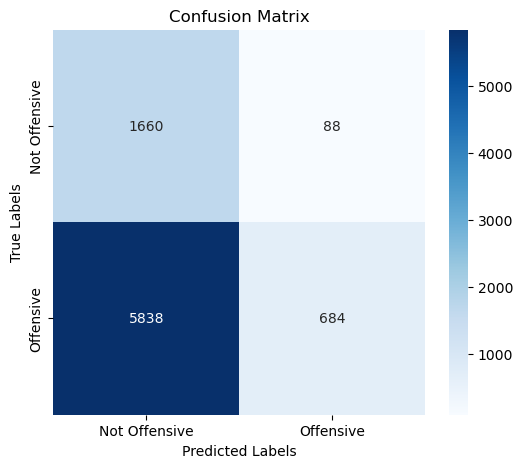

In [7]:
classified_df['pred_label'] = classified_df['prediction'].map({'Not Offensive': 0, 'Offensive': 1})

evaluate_model(classified_df["true_label"],y_pred =  classified_df["pred_label"],class_labels=candidate_labels)

### TDavidson

In [8]:
from datasets import load_dataset

ds = load_dataset("tdavidson/hate_speech_offensive")

In [9]:
td = ds['train'].to_pandas()
td.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [10]:
td['true_label'] = td['class'].apply(lambda x: 1 if x == 1 else 0)
td.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,true_label
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [11]:
td_classified = classify_tweets(td, text_column="tweet", candidate_labels=candidate_labels, batch_size=16)
td_classified.head()

Device set to use cuda
Classifying tweets: 100%|██████████| 1549/1549 [20:52<00:00,  1.24it/s]


,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,true_label,prediction
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0,Not Offensive
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,Offensive
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1,Offensive
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1,Offensive
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,Offensive



📊 Classification Report:
               precision    recall  f1-score   support

Not Offensive       0.88      0.57      0.69      5593
    Offensive       0.89      0.98      0.93     19190

     accuracy                           0.89     24783
    macro avg       0.88      0.77      0.81     24783
 weighted avg       0.88      0.89      0.88     24783


✅ Accuracy: 0.8851
✅ Precision: 0.8863
✅ Recall: 0.9770
✅ F1 Score: 0.9294


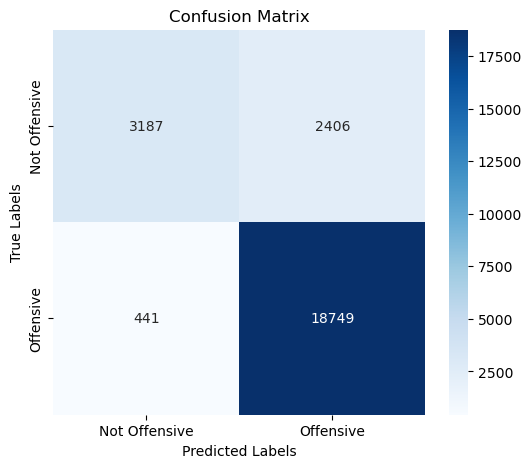

In [12]:
td_classified['pred_label'] = td_classified['prediction'].map({'Not Offensive': 0, 'Offensive': 1})

evaluate_model(td_classified["true_label"],y_pred =  td_classified["pred_label"],class_labels=candidate_labels)

In [13]:
td_classified.to_csv("TDavidson_tasksource_deberta.csv", index=False)